In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline

from pymbar import timeseries

import calibration_tools as tools

DISCARD = 10
FAST = False

# Comparing predicted concentration with observed

Extracting the tip3p calibration results

In [2]:
files = ['../sams/tip3p/out1.nc', '../sams/tip3p/out2.nc', '../sams/tip3p/out3.nc']
t3p = tools.AutoAnalyzeCalibration(files)

For each chemical potential, calculating the mean salt concentration as a function of iteration and using `pymbar`'s timeseries analysis to estimate the standard error on the mean.

In [3]:
# The chemical potentials that were simulated.
mu = [314.85, 315.24, 315.68, 316.39, 317.61, 318.78, 319.83]

# Pre-assignment for results
mean_concentrations = np.zeros(len(mu))
standard_error = np.zeros(len(mu))

for i in range(len(mu)):
    # Reading the data
    file = '../equilibrium_staging/tip3p/deltamu_' + str(mu[i]) + '/out.nc'
    ncfile = Dataset(file,'r')
    volume = ncfile.groups['Sample state data']['volume'][:]
    nsalt = ncfile.groups['Sample state data']['species counts'][:,1]
    ncfile.close()
    
    # Get the concentrations
    concentration = 1.0*nsalt/volume * 1.66054
    
    # Estimate the mean and standard error with timeseries analysis
    t_equil, stat_ineff, n_eff = timeseries.detectEquilibration(concentration[DISCARD:], fast=FAST)
    mean_concentrations[i] = np.mean(concentration[(DISCARD + t_equil):])
    standard_error[i] = np.std(concentration[(DISCARD + t_equil):]) / np.sqrt(n_eff)

Based on the above chemical potentials, estimating the uncertainty on the predicted concentration via bootstrap sampling. Using the 95% confidence intervals to measure the uncertainty.

In [4]:
plot_mus = np.linspace(mu[0],mu[-1])
pred_concentration, pred_spread =  t3p.predict_ensemble_concentrations(deltachems=plot_mus, nsamples=500)
lower = np.percentile(pred_spread, q=2.5, axis=1)
upper = np.percentile(pred_spread, q=97.5, axis=1)

Plotting the results:

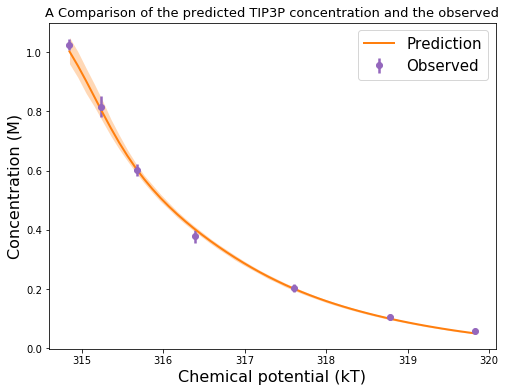

In [5]:
plt.figure(figsize=[8,6])

# Picking the plotting colors:
c_pred = 'C1'
c_obs = 'C4'

# Plotting the prediction and confidence interval
plt.plot(plot_mus, pred_concentration,color=c_pred, label='Prediction', lw=2)
plt.fill_between(x=plot_mus, y1=lower, y2=upper, color=c_pred, alpha=0.3, lw=0)

# Plotting the observed concentration with estimated 95% confidence interval
plt.errorbar(mu, mean_concentrations,yerr=2*standard_error, fmt='o', color=c_obs, label='Observed', lw=2.5)

plt.title('A Comparison of the predicted TIP3P concentration and the observed',fontsize=13)
plt.xlabel('Chemical potential (kT)', fontsize=16)
plt.ylabel('Concentration (M)', fontsize=16)
plt.legend(fontsize=15)
plt.show()

# Viewing traces from a single simulation

In [6]:
mu='316.39'

In [7]:
file = '../equilibrium_staging/tip3p/deltamu_' + mu + '/out.nc'
ncfile = Dataset(file,'r')
volume = ncfile.groups['Sample state data']['volume'][:]
nsalt = ncfile.groups['Sample state data']['species counts'][:,1]
ncfile.close()

### Salt numbers

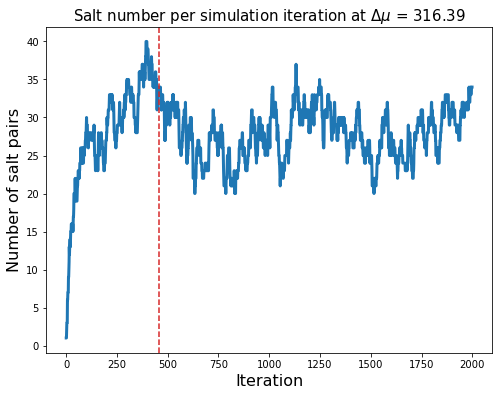

In [8]:
t_equil, stat_ineff, n_eff = timeseries.detectEquilibration(nsalt[DISCARD:], fast=FAST)

plt.figure(figsize=[8,6])
plt.plot(nsalt, lw=3)
plt.axvline(t_equil+DISCARD, ls='--', color='C3')

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Number of salt pairs', fontsize=16)
plt.title('Salt number per simulation iteration at $\Delta \mu$ = {0}'.format(mu), fontsize=15)
plt.show()

### Volume

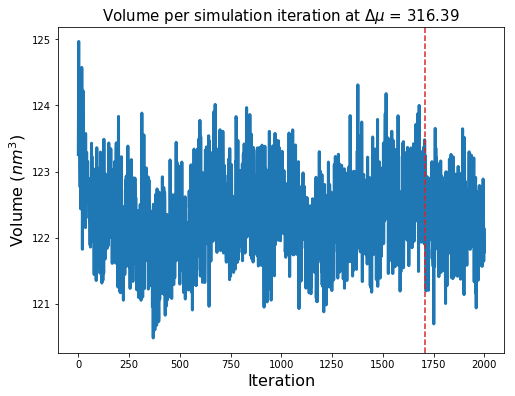

Equilibrium detected at iteration 1709


In [9]:
t_equil, stat_ineff, n_eff = timeseries.detectEquilibration(volume[DISCARD:], fast=FAST)

plt.figure(figsize=[8,6])
plt.plot(volume, lw=3)
plt.axvline(t_equil+DISCARD, ls='--', color='C3')

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Volume ($nm^3$)', fontsize=16)
plt.title('Volume per simulation iteration at $\Delta \mu$ = {0}'.format(mu), fontsize=15)
plt.show()

print('Equilibrium detected at iteration {0}'.format(t_equil+DISCARD))

### Concentration

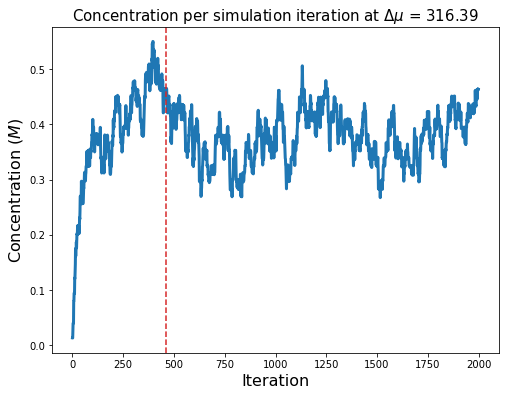

Equilibrium detected at iteration 459


In [10]:
concentration = 1.0*nsalt/volume * 1.66054  # in M
t_equil, stat_ineff, n_eff = timeseries.detectEquilibration(concentration[DISCARD:], fast=FAST)

plt.figure(figsize=[8,6])
plt.plot(concentration, lw=3)
plt.axvline(t_equil+DISCARD, ls='--', color='C3')

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Concentration ($M$)', fontsize=16)
plt.title('Concentration per simulation iteration at $\Delta \mu$ = {0}'.format(mu), fontsize=15)
plt.show()

print('Equilibrium detected at iteration {0}'.format(t_equil+DISCARD))

### Viewing the distribution of salt in a single simulation

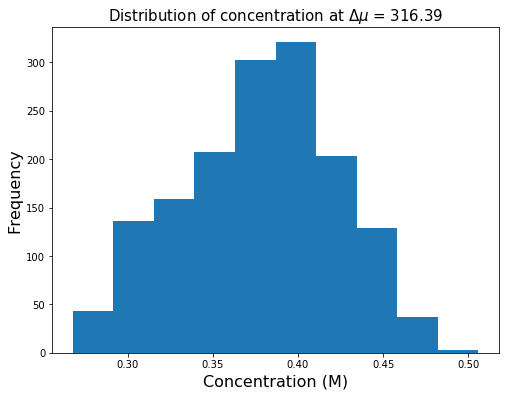

In [11]:
plt.figure(figsize=[8,6])
plt.hist(concentration[(t_equil + DISCARD):])
plt.title('Distribution of concentration at $\Delta \mu$ = {0}'.format(mu), fontsize=15)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Concentration (M)', fontsize=16)
plt.show()